In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import src.time_series_helpers as th

%matplotlib inline
plt.style.use('ggplot')

In [4]:
ls data/

LSTM_10_output_forecast.csv  processed_train.csv
LSTM_500_by_item.csv         sample_submission.csv
LSTM_500_forecast.csv        sample_valid.csv
VAR_by_item.csv              store_item.csv
VAR_forecast.csv             test.csv
lstm_10_by_item.csv          train.csv
lstm_data.csv


In [5]:
df = pd.read_csv('data/train.csv')

In [6]:
df.shape

(913000, 4)

In [7]:
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [9]:
#check the na values
df.isnull().sum()

#No missing value. great.

date     0
store    0
item     0
sales    0
dtype: int64

In [10]:
#Get the lowest and highest dates in the dataset.
df['date'].min() , df['date'].max()

#there is data for 5 years. great.

('2013-01-01', '2017-12-31')

#####  raw data information
We have in our training data :
 - date  - every date of items sold
 - store - unique number of every shop(1-10)
 - item  - unique number of every item(1-50)
 - sales - items sold on a particular day and a particular store
 
 -4 years observed data, no missing values

In [12]:
#set datatime to index
df['date'] = pd.to_datetime(df['date'])
# df = df.set_index('date')

In [13]:
df.info(),df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


(None,
         date  store  item  sales
 0 2013-01-01      1     1     13
 1 2013-01-02      1     1     11
 2 2013-01-03      1     1     14
 3 2013-01-04      1     1     13
 4 2013-01-05      1     1     10)

In [14]:
df['year']= df.date.dt.year
df['month']= df.date.dt.month
df['day']= df.date.dt.day
df['day_of_week']=df.date.dt.dayofweek
df['year_and_month']= df.date.dt.to_period('M')

In [15]:
df.head(5)

,date,store,item,sales,year,month,day,day_of_week,year_and_month
0,2013-01-01,1,1,13,2013,1,1,1,2013-01
1,2013-01-02,1,1,11,2013,1,2,2,2013-01
2,2013-01-03,1,1,14,2013,1,3,3,2013-01
3,2013-01-04,1,1,13,2013,1,4,4,2013-01
4,2013-01-05,1,1,10,2013,1,5,5,2013-01


In [16]:
#assign 1 if the day of week is a weekend and 
# 0 if the day of week in not a weekend
def applyer(row):
    if row.dayofweek ==5 or row.dayofweek ==6:
        return 1
    else: 
        return 0

In [17]:
temp = df.date.apply(applyer)
df['weekend']=temp

In [18]:
df = df.set_index('date')
df.head(5)

,store,item,sales,year,month,day,day_of_week,year_and_month,weekend
date,,,,,,,,,
2013-01-01,1,1,13,2013,1,1,1,2013-01,0
2013-01-02,1,1,11,2013,1,2,2,2013-01,0
2013-01-03,1,1,14,2013,1,3,3,2013-01,0
2013-01-04,1,1,13,2013,1,4,4,2013-01,0
2013-01-05,1,1,10,2013,1,5,5,2013-01,1


In [19]:
def plot_trend_data(ax, name, series):
    ax.plot(series.index, series.values)
    ax.set_title("Sales Trend For {}".format(name))
    
    

#### look at yearly sales

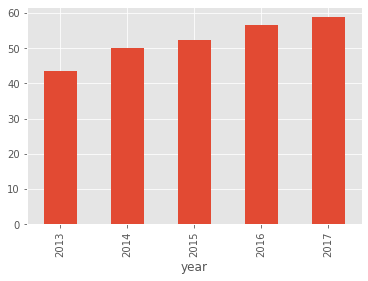

In [31]:
yearly = df.groupby('year')['sales'].mean()
yearly.plot.bar()

#### look at monthly sales

In [32]:
monthly = df.groupby(pd.Grouper(freq='M'))['sales'].mean()
monthly.columns =['sales']
monthly

date
2013-01-31    29.348645
2013-02-28    32.815500
2013-03-31    39.831097
2013-04-30    45.484933
2013-05-31    49.241419
2013-06-30    53.039800
2013-07-31    55.220774
2013-08-31    49.468452
2013-09-30    45.993800
2013-10-31    42.360452
2013-11-30    46.176200
2013-12-31    32.684323
2014-01-31    33.934645
2014-02-28    37.794071
2014-03-31    45.438774
2014-04-30    52.594267
2014-05-31    56.959806
2014-06-30    60.456133
2014-07-31    63.807097
2014-08-31    57.135226
2014-09-30    52.341600
2014-10-31    48.960194
2014-11-30    53.385533
2014-12-31    37.293419
2015-01-31    35.646000
2015-02-28    39.379786
2015-03-31    47.158129
2015-04-30    54.964467
2015-05-31    59.800129
2015-06-30    62.478933
2015-07-31    66.925806
2015-08-31    59.380710
2015-09-30    54.888800
2015-10-31    51.435677
2015-11-30    55.176333
2015-12-31    39.198194
2016-01-31    38.867032
2016-02-29    42.410828
2016-03-31    51.024581
2016-04-30    60.130000
2016-05-31    63.789032
2016-06-30 

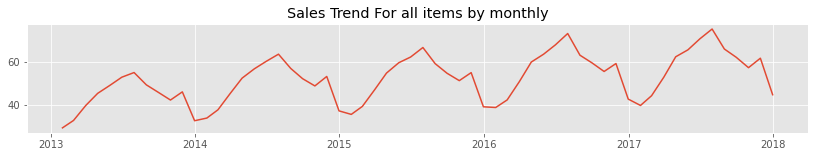

In [33]:
fig, ax = plt.subplots(1, figsize=(14, 2))
th.plot_trend_data(ax, 'all items by monthly', monthly)
plt.savefig('images/all_items_by_monthly.png')

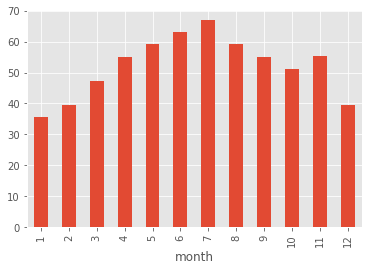

In [34]:
df.groupby('month')['sales'].mean().plot.bar()

#### look at weekly sales

In [35]:
weekly = df.groupby(pd.Grouper(freq='W'))['sales'].mean()
weekly.columns =['sales']
weekly

date
2013-01-06    30.355667
2013-01-13    29.686286
2013-01-20    29.414286
2013-01-27    29.513714
2013-02-03    31.150571
                ...    
2017-12-03    53.510286
2017-12-10    44.114286
2017-12-17    44.370286
2017-12-24    44.423429
2017-12-31    44.417429
Freq: W-SUN, Name: sales, Length: 261, dtype: float64

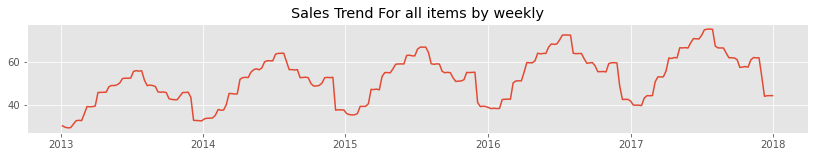

In [36]:
fig, ax = plt.subplots(1, figsize=(14, 2))
plot_trend_data(ax, 'all items by weekly', weekly)
plt.savefig('images/all_items_by_weekly.png')

#### look at daily sales

In [37]:
daily = df['sales'].resample('d').mean()
type(daily),daily.head()

(pandas.core.series.Series,
 date
 2013-01-01    27.392
 2013-01-02    27.356
 2013-01-03    28.976
 2013-01-04    31.354
 2013-01-05    32.474
 Freq: D, Name: sales, dtype: float64)

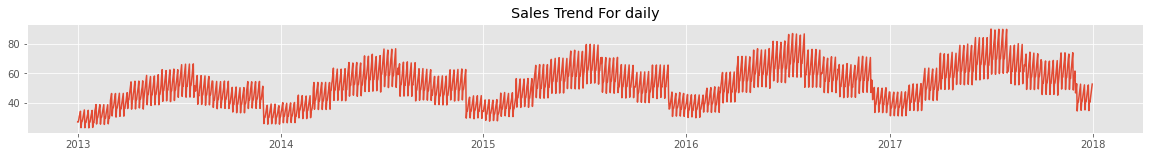

In [38]:
daily.columns =['sales']
fig, ax = plt.subplots(1, figsize=(20, 2))
plot_trend_data(ax, 'daily', daily)

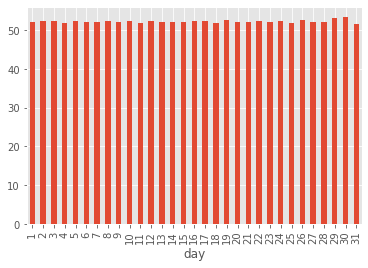

In [39]:
df.groupby('day')['sales'].mean().plot.bar()

#### look at weekdays

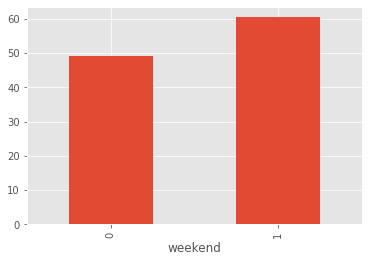

In [40]:
df.groupby('weekend')['sales'].mean().plot.bar()

#### look at the day wise dales

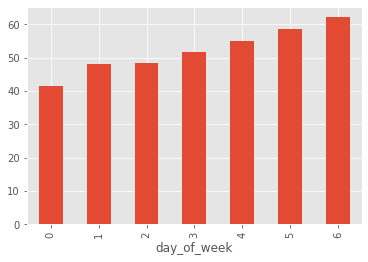

In [41]:
df.groupby('day_of_week')['sales'].mean().plot.bar()

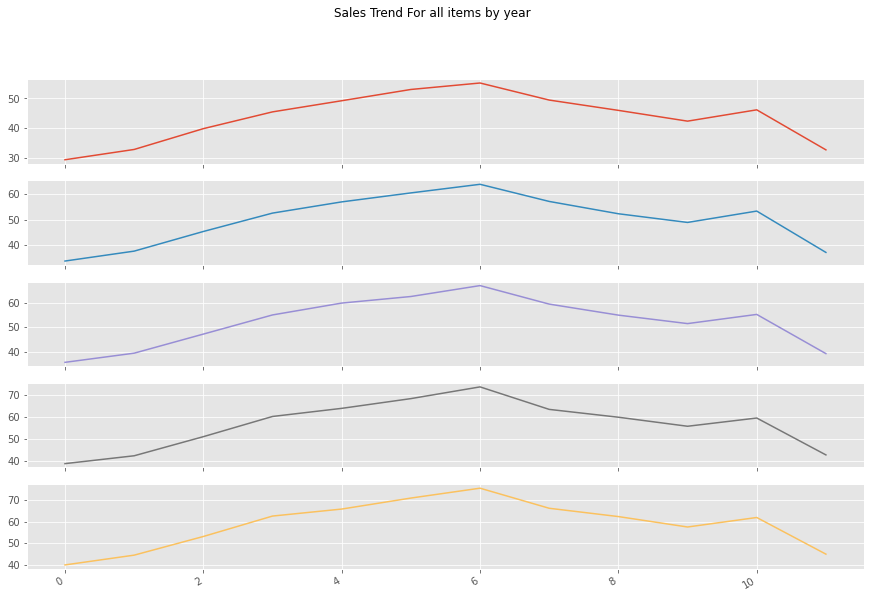

<Figure size 432x288 with 0 Axes>

In [42]:
groups = monthly.groupby(pd.Grouper(freq='Y'))
years = pd.DataFrame()
for name, group in groups:
    years[name.year] = group.values
years.plot(subplots=True, legend=False,title ='Sales Trend For all items by year',figsize=(15,10))
plt.show()
plt.savefig('images/all_items_by_monthly_and_by_year.png')

In [43]:
years

,2013,2014,2015,2016,2017
0,29.348645,33.934645,35.646000,38.867032,39.826194
1,32.815500,37.794071,39.379786,42.410828,44.383500
2,39.831097,45.438774,47.158129,51.024581,53.075290
3,45.484933,52.594267,54.964467,60.130000,62.590800
4,49.241419,56.959806,59.800129,63.789032,65.850710
5,53.039800,60.456133,62.478933,68.177600,70.974933
6,55.220774,63.807097,66.925806,73.465677,75.573742
7,49.468452,57.135226,59.380710,63.322194,66.219548
8,45.993800,52.341600,54.888800,59.788733,62.350867
9,42.360452,48.960194,51.435677,55.718516,57.494194


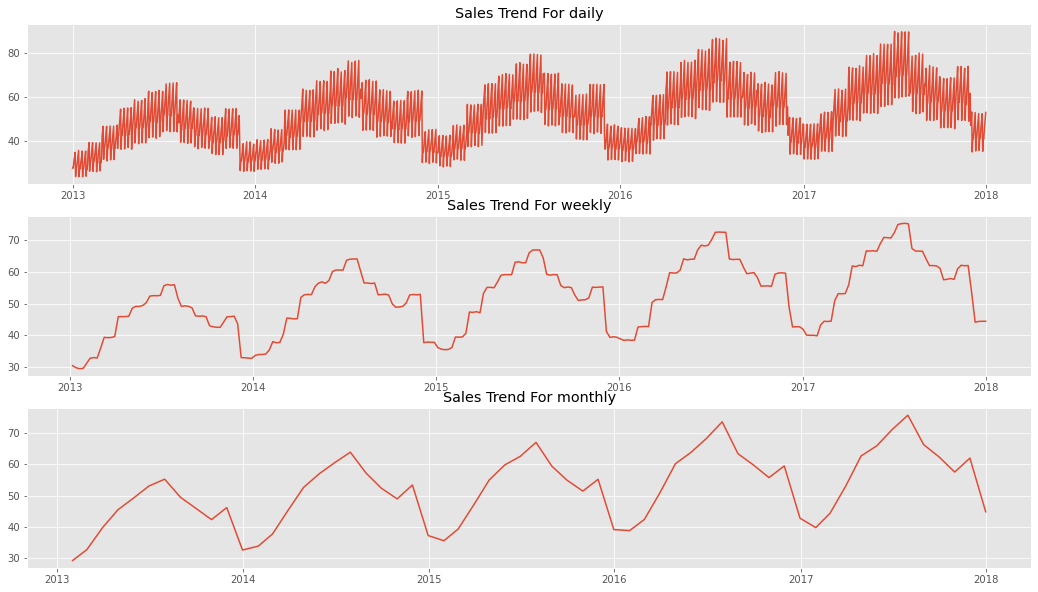

In [44]:
ts_list = [daily,weekly,monthly]
titles  = ['daily','weekly','monthly']
fig, axs = plt.subplots(3,1, figsize=(18,10))
for i,ts in enumerate(ts_list):
    plot_trend_data(axs[i], titles[i], ts)


In [45]:
df.head()

,store,item,sales,year,month,day,day_of_week,year_and_month,weekend
date,,,,,,,,,
2013-01-01,1,1,13,2013,1,1,1,2013-01,0
2013-01-02,1,1,11,2013,1,2,2,2013-01,0
2013-01-03,1,1,14,2013,1,3,3,2013-01,0
2013-01-04,1,1,13,2013,1,4,4,2013-01,0
2013-01-05,1,1,10,2013,1,5,5,2013-01,1


In [46]:
# add some column for late feature engineering
df['quarter'] = df.index.quarter
df['week_block_num'] = [int(x) for x in np.floor((df.index - pd.to_datetime('2012-12-31')).days/7) + 1]
df['quarter_block_num'] = (df.index.year - 2013) * 4 + df['quarter']

In [47]:
df.head()

,store,item,sales,year,month,day,day_of_week,year_and_month,weekend,quarter,week_block_num,quarter_block_num
date,,,,,,,,,,,,
2013-01-01,1,1,13,2013,1,1,1,2013-01,0,1,1,1
2013-01-02,1,1,11,2013,1,2,2,2013-01,0,1,1,1
2013-01-03,1,1,14,2013,1,3,3,2013-01,0,1,1,1
2013-01-04,1,1,13,2013,1,4,4,2013-01,0,1,1,1
2013-01-05,1,1,10,2013,1,5,5,2013-01,1,1,1,1


In [48]:
df.shape

(913000, 12)

In [49]:
df.to_csv('data/processed_train.csv',index =True)

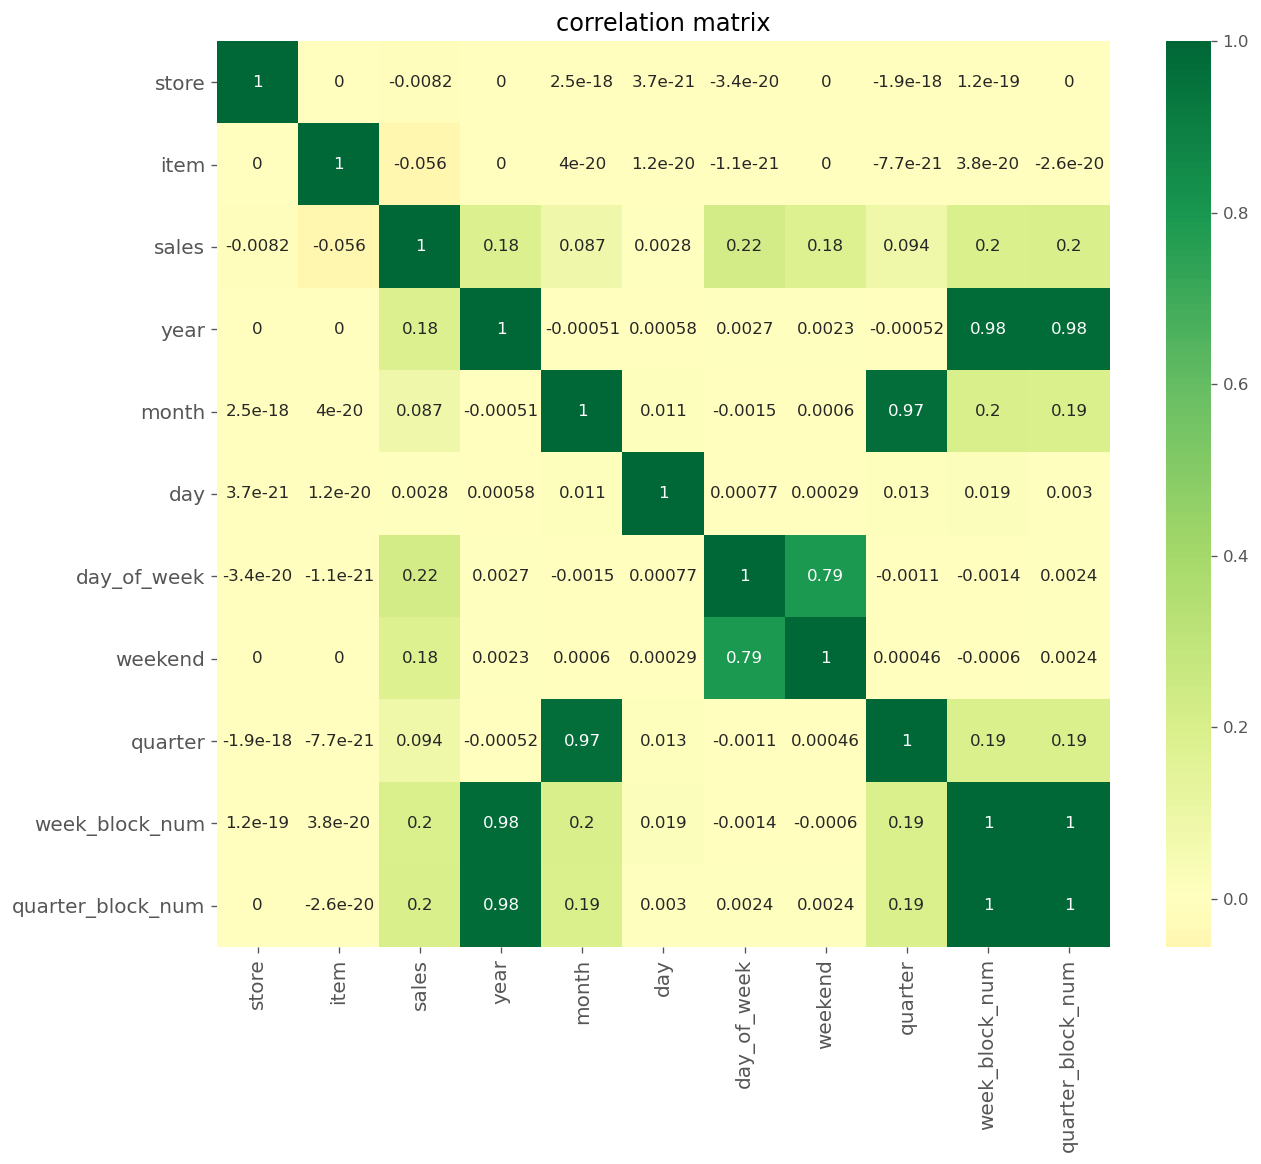

In [57]:
plt.figure(figsize=(12,10), dpi= 120)
sns.heatmap(df.corr(), xticklabels=df.corr().columns, yticklabels=df.corr().columns, cmap='RdYlGn', center=0, annot=True)

# Decorations

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('correlation matrix')
plt.savefig('images/correlation_matrix.png')
plt.show()

#### Univariate Analysis - Store

In [106]:
df['store'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [107]:
#cuont numbers of stores
store_nums = len(df['store'].unique())
store_nums

10

In [218]:
df.groupby('store')['sales'].sum().sort_values(ascending=False)

store
2     6120128
8     5856169
3     5435144
10    5360158
9     5025976
4     5012639
1     4315603
5     3631016
6     3627670
7     3320009
Name: sales, dtype: int64

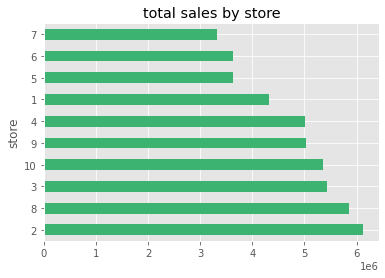

In [217]:
df.groupby('store').sum()['sales'].sort_values(ascending=False).plot(kind='barh', color ='mediumseagreen',title = 'total sales by store')

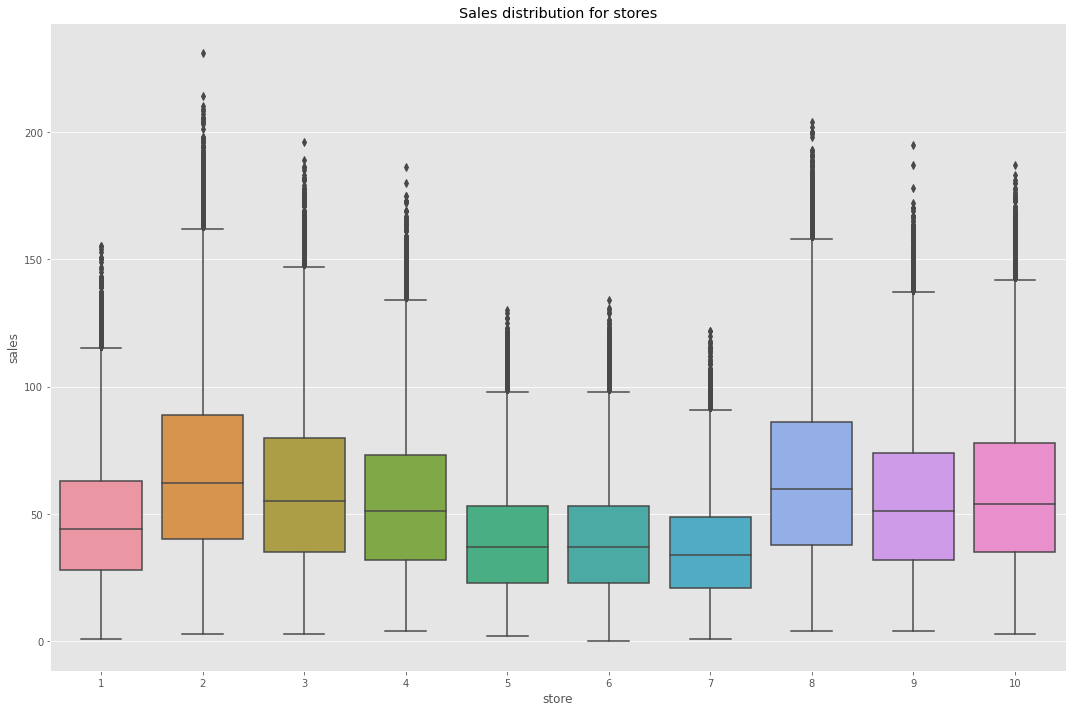

In [50]:
fig, ax = plt.subplots(figsize = (15,10))
ax = sns.boxplot( df['store'],df['sales'])
ax.set_title('Sales distribution for stores')

plt.tight_layout()
plt.savefig('images/Sales_distribution_for_stores.png')

In [51]:
stores = df.groupby(['store','year_and_month'])['sales'].sum()
stores = stores.reset_index()

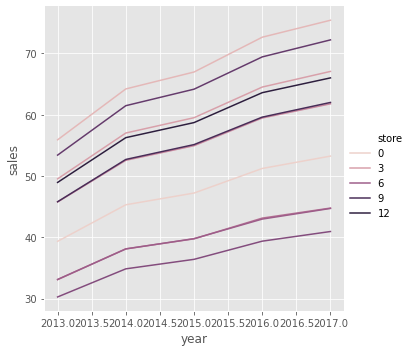

In [76]:
data = df.groupby(['store','year'])
mean = data[["sales"]].mean()
mean = mean.add_suffix('').reset_index()
sns.relplot(y="sales", x="year", data=mean, kind="line", hue="store")

plt.savefig('images/Sales_trend_by_stores.png')

In [52]:
x = stores.year_and_month.unique()
x

<PeriodArray>
['2013-01', '2013-02', '2013-03', '2013-04', '2013-05', '2013-06', '2013-07',
 '2013-08', '2013-09', '2013-10', '2013-11', '2013-12', '2014-01', '2014-02',
 '2014-03', '2014-04', '2014-05', '2014-06', '2014-07', '2014-08', '2014-09',
 '2014-10', '2014-11', '2014-12', '2015-01', '2015-02', '2015-03', '2015-04',
 '2015-05', '2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-11',
 '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06',
 '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01',
 '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08',
 '2017-09', '2017-10', '2017-11', '2017-12']
Length: 60, dtype: period[M]

In [53]:
stores.sales.min(),stores.sales.max()

(31508, 150105)

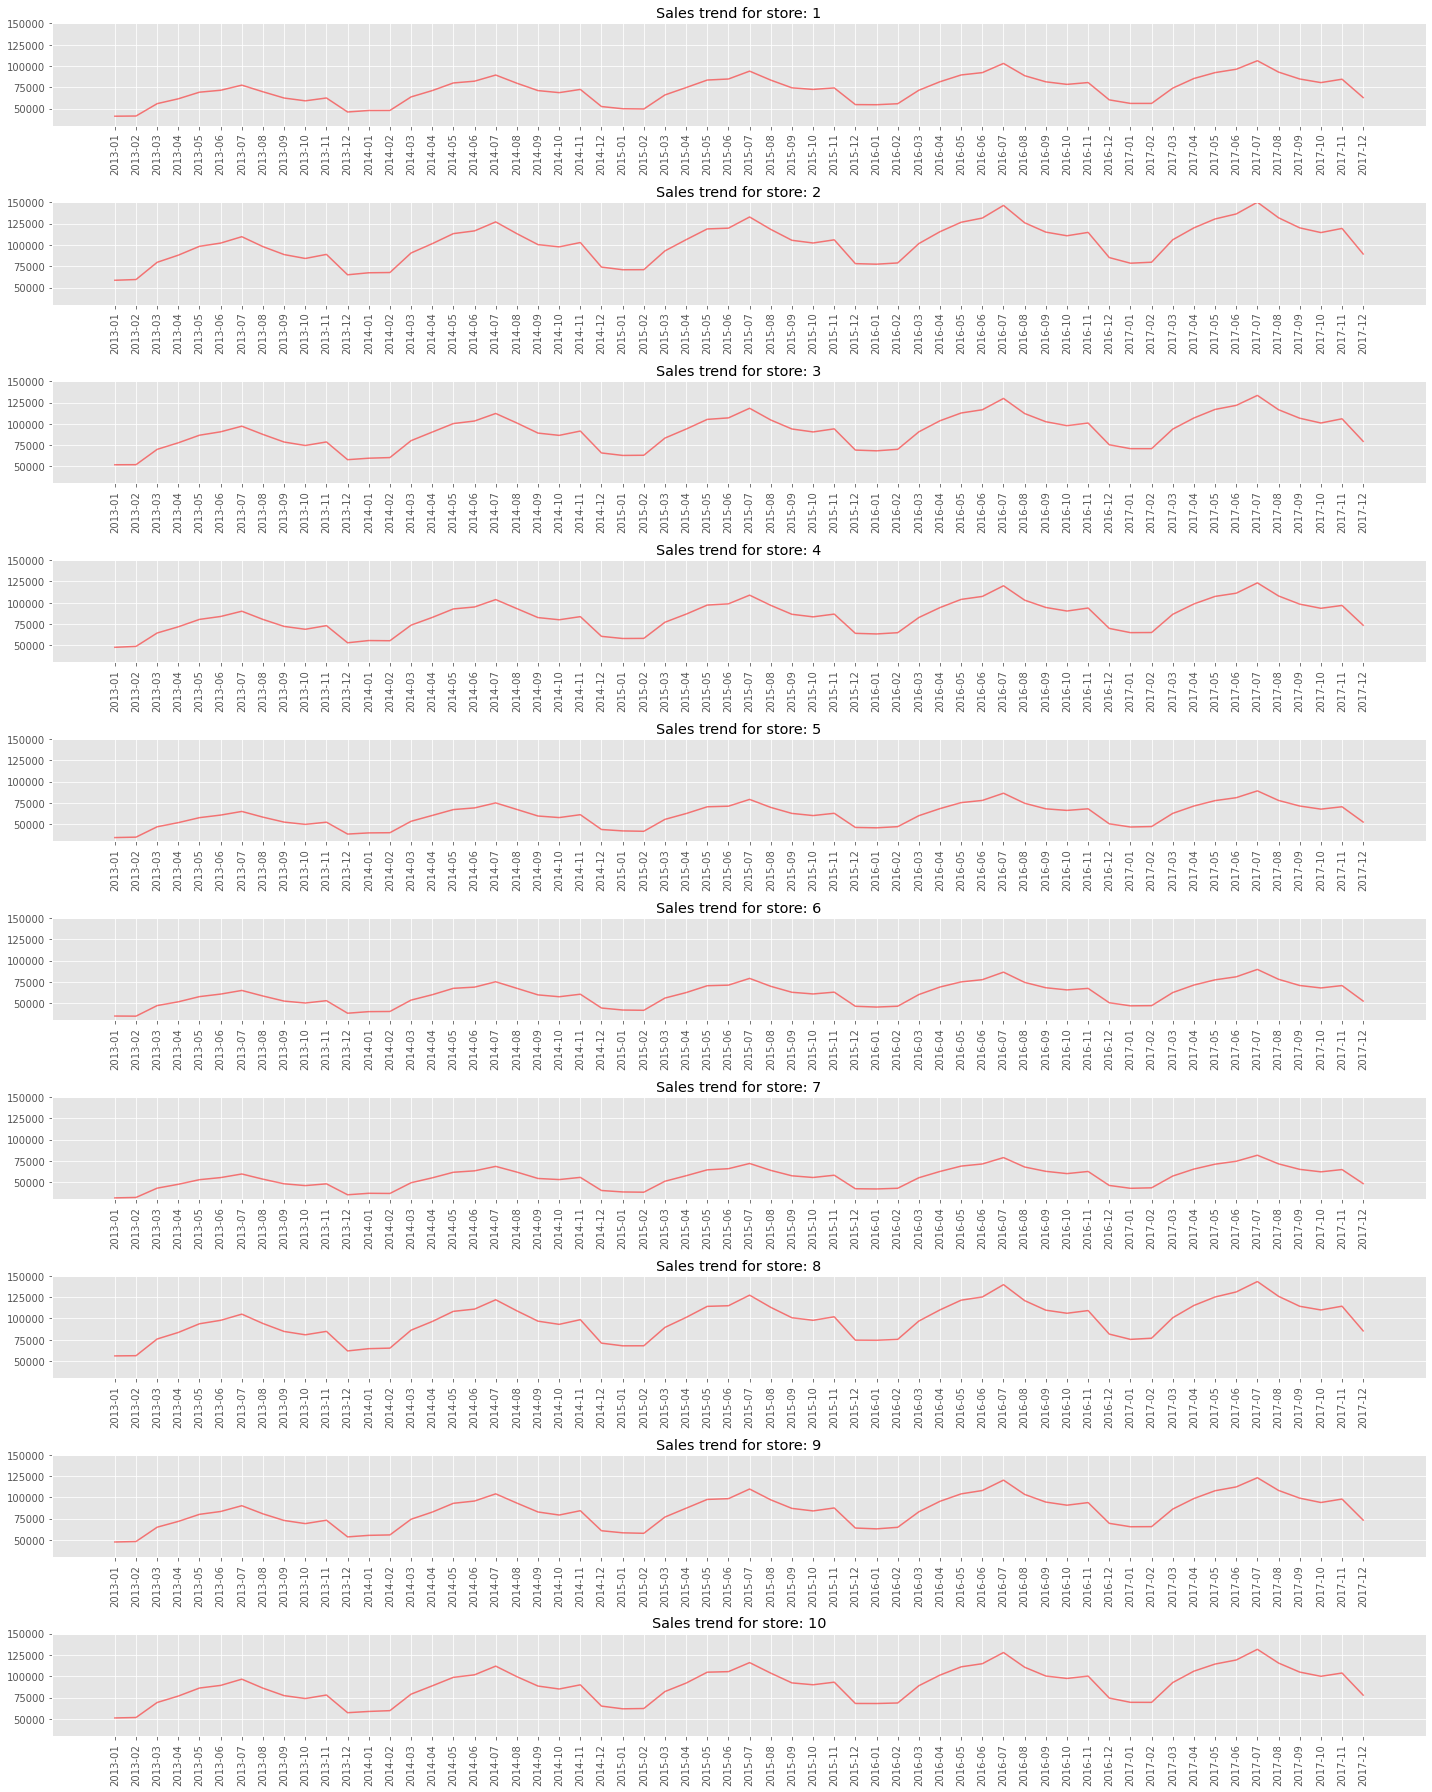

In [54]:
fig,axs = plt.subplots(10,1,figsize=(20,25))

for i, ax in enumerate(axs.flatten()):
    store = stores[stores['store']==(i+1)]
    ax.plot(np.arange(len(x)),store.sales, c="r", alpha=0.5)
    ax.set_title(f"Sales trend for store: {i+1}")
    ax.set_xticks(np.arange(len(x)))
    ax.set_xticklabels(x, rotation='vertical')
    ax.set_ylim([30000,150000])

plt.tight_layout()
plt.savefig('images/Sales_trend_for_stores.png')

####  There are seasonal patterns in the data
Sales show very strong oscillations aligned with the season. Sales volume increases quickly as the summer begins, and then falls off as summer goes on.

#### Univariate Analysis - Item

In [72]:
item_nums = len(df['item'].unique())
item_nu

50

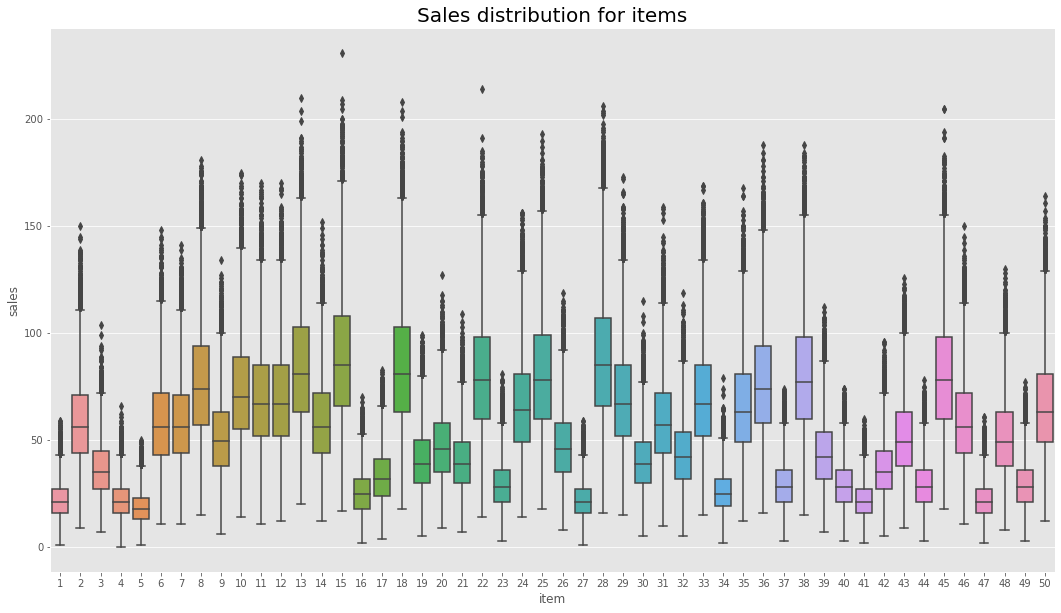

In [71]:
fig, ax = plt.subplots(figsize = (18,10))
ax = sb.boxplot( df['item'],df['sales'])
ax.set_title('Sales distribution for items',fontsize=20)
plt.savefig('images/Sales_distribution_for_items.png')

In [65]:
items = df.groupby(['item','year_and_month'])['sales'].mean()
items =items.reset_index()
items

,item,year_and_month,sales
0,1,2013-01,12.238710
1,1,2013-02,13.796429
2,1,2013-03,16.741935
3,1,2013-04,19.276667
4,1,2013-05,20.316129
...,...,...,...
2995,50,2017-08,83.480645
2996,50,2017-09,77.693333
2997,50,2017-10,72.109677
2998,50,2017-11,77.643333


In [66]:
items.sales.min(),items.sales.max(),

(10.009677419354839, 127.49677419354839)

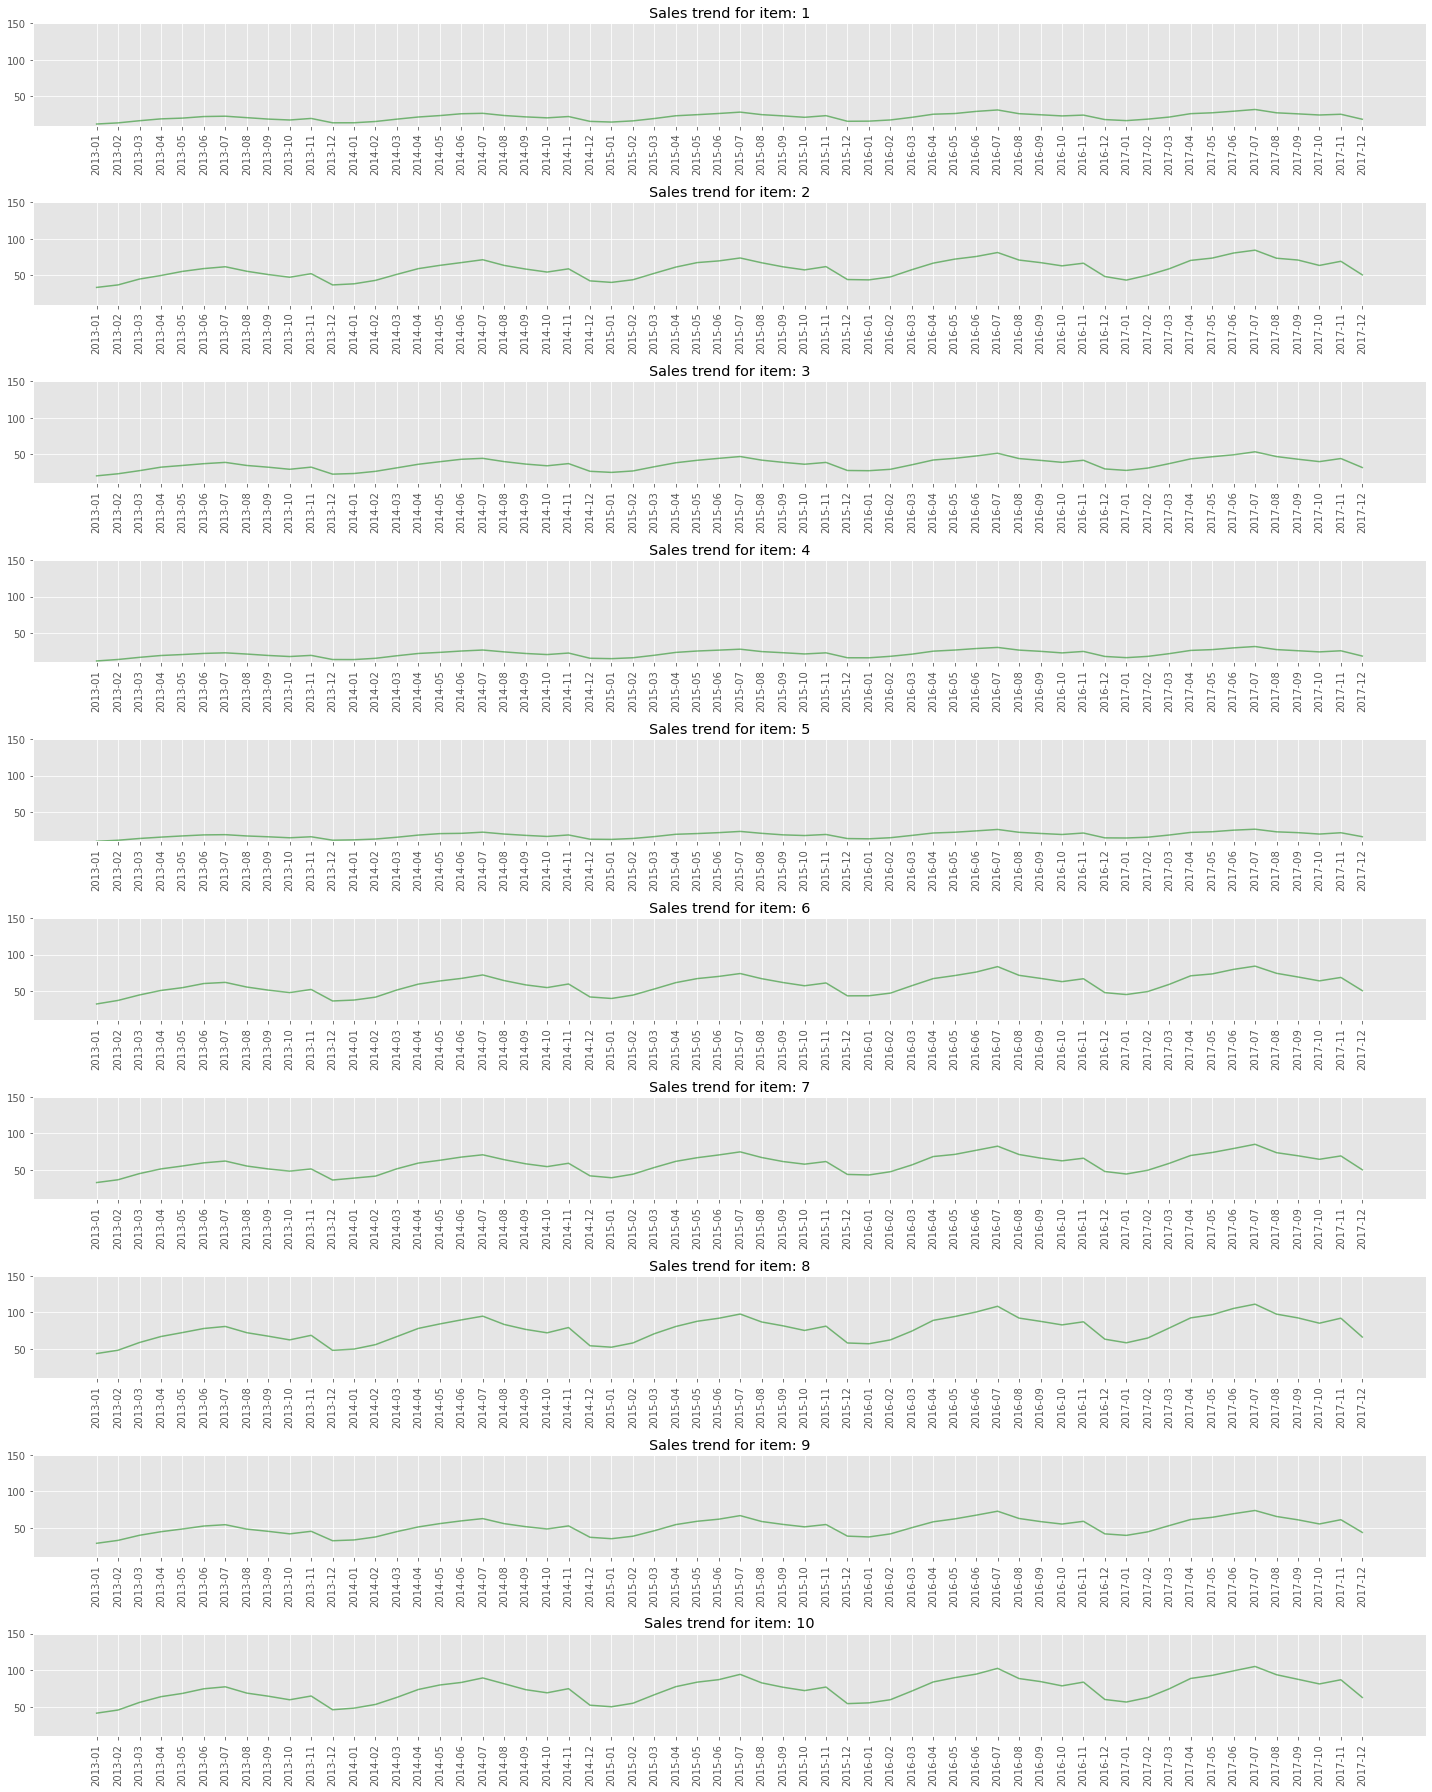

In [67]:
# First 10 items sales trend
fig,axs = plt.subplots(10,1,figsize=(20,25))

for i, ax in enumerate(axs.flatten()):
    item = items[items['item']==(i+1)]
    ax.plot(np.arange(len(x)),item.sales, c="g", alpha=0.5)
    ax.set_title(f"Sales trend for item: {i+1}")
    ax.set_xticks(np.arange(len(x)))
    ax.set_xticklabels(x, rotation='vertical')
    ax.set_ylim([10,150])

plt.tight_layout()
plt.savefig('images/Sales_trend_for_first_10_items.png')

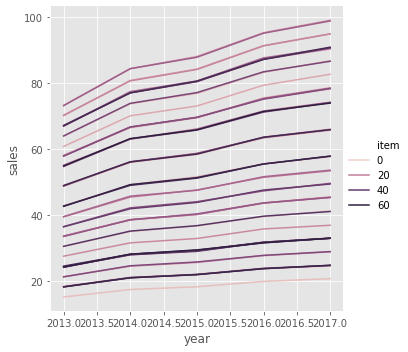

In [72]:
data = df.groupby(['item',"year"])
mean = data[["sales"]].mean()
mean = mean.add_suffix('').reset_index()
g = sns.relplot(y="sales", x="year", data=mean, kind="line", hue="item")

In [87]:
sales_data = df.iloc[:,:3]
sales_data.shape

(913000, 3)

,store,item,sales
date,,,
2017-01-16,5,48,27
2017-01-17,5,48,20
2017-01-18,5,48,35
2017-01-19,5,48,29
2017-01-20,5,48,29
...,...,...,...
2017-12-27,10,50,63
2017-12-28,10,50,59
2017-12-29,10,50,74


In [170]:
sample_train = df.loc['2013-01-01':'2017-09-30']
sample_train.sales.sum()

45189345

In [171]:
sample_valid = sales_data['2017-10-1':]
sample_valid.sales.sum()

2515167

In [173]:
df.sales.sum() ==(sample_train.sales.sum()+sample_valid.sales.sum())

True

In [174]:
sample_valid.shape

(46000, 3)

In [178]:
sample_valid.columns =['store', 'item', 'actuals']

In [179]:
sample_valid.head()

,store,item,actuals
date,,,
2017-10-01,1,1,21
2017-10-02,1,1,12
2017-10-03,1,1,18
2017-10-04,1,1,15
2017-10-05,1,1,20


In [180]:
sample_valid.to_csv('data/sample_valid.csv',index =True)

In [90]:
# pandas cap


In [137]:
store_item = pd.pivot_table(sales_data, values='sales', index=['date'],
                    columns=['store','item'], aggfunc=np.sum)

In [138]:
store_item.head()

store       1                                       ...  10                  \
item        1   2   3   4   5   6   7   8   9   10  ...  41  42  43  44  45   
date                                                ...                       
2013-01-01  13  33  15  10  11  31  25  33  18  37  ...  12  20  24  17  45   
2013-01-02  11  43  30  11   6  36  23  37  23  34  ...  10  22  29  10  45   
2013-01-03  14  23  14   8   8  18  34  38  25  32  ...  17  27  43  20  56   
2013-01-04  13  18  10  19   9  19  36  54  22  45  ...  13  24  27  12  50   
2013-01-05  10  34  23  12   8  31  38  51  29  35  ...  14  25  31  25  62   

store                           
item        46  47  48  49  50  
date                            
2013-01-01  37  11  25  17  33  
2013-01-02  33  13  24  13  37  
2013-01-03  28  16  29  19  46  
2013-01-04  44  11  39  23  51  
2013-01-05  45  16  34  22  41  

[5 rows x 500 columns]

In [142]:
store_item.columns

MultiIndex([( 1,  1),
            ( 1,  2),
            ( 1,  3),
            ( 1,  4),
            ( 1,  5),
            ( 1,  6),
            ( 1,  7),
            ( 1,  8),
            ( 1,  9),
            ( 1, 10),
            ...
            (10, 41),
            (10, 42),
            (10, 43),
            (10, 44),
            (10, 45),
            (10, 46),
            (10, 47),
            (10, 48),
            (10, 49),
            (10, 50)],
           names=['store', 'item'], length=500)

In [145]:
lst=['s'+'2','i'+'10']
lst

['s2', 'i10']

In [146]:
lst = []
for i in store_item.columns:
    col = '_'.join(['s'+str(col[0]),'i'+str(col[1])])
    print(col)

ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_is
ss_i

In [147]:
store_item.columns = ["_".join(['s'+str(col[0]),'i'+str(col[1])]) for col in store_item.columns]
store_item.columns

Index(['s1_i1', 's1_i2', 's1_i3', 's1_i4', 's1_i5', 's1_i6', 's1_i7', 's1_i8',
       's1_i9', 's1_i10',
       ...
       's10_i41', 's10_i42', 's10_i43', 's10_i44', 's10_i45', 's10_i46',
       's10_i47', 's10_i48', 's10_i49', 's10_i50'],
      dtype='object', length=500)

In [148]:
type(store_item)

pandas.core.frame.DataFrame

In [149]:
store_item.head()

,s1_i1,s1_i2,s1_i3,s1_i4,s1_i5,s1_i6,s1_i7,s1_i8,s1_i9,s1_i10,...,s10_i41,s10_i42,s10_i43,s10_i44,s10_i45,s10_i46,s10_i47,s10_i48,s10_i49,s10_i50
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,13,33,15,10,11,31,25,33,18,37,...,12,20,24,17,45,37,11,25,17,33
2013-01-02,11,43,30,11,6,36,23,37,23,34,...,10,22,29,10,45,33,13,24,13,37
2013-01-03,14,23,14,8,8,18,34,38,25,32,...,17,27,43,20,56,28,16,29,19,46
2013-01-04,13,18,10,19,9,19,36,54,22,45,...,13,24,27,12,50,44,11,39,23,51
2013-01-05,10,34,23,12,8,31,38,51,29,35,...,14,25,31,25,62,45,16,34,22,41


In [150]:
store_item.to_csv('data/store_item.csv',index =True)

In [153]:
df

,store,item,sales,year,month,day,day_of_week,year_and_month,weekend
date,,,,,,,,,
2013-01-01,1,1,13,2013,1,1,1,2013-01,0
2013-01-02,1,1,11,2013,1,2,2,2013-01,0
2013-01-03,1,1,14,2013,1,3,3,2013-01,0
2013-01-04,1,1,13,2013,1,4,4,2013-01,0
2013-01-05,1,1,10,2013,1,5,5,2013-01,1
...,...,...,...,...,...,...,...,...,...
2017-12-27,10,50,63,2017,12,27,2,2017-12,0
2017-12-28,10,50,59,2017,12,28,3,2017-12,0
2017-12-29,10,50,74,2017,12,29,4,2017-12,0


In [278]:
sample_train = df.loc['2013-01-01':'2017-09-30']
sample_train.sales.sum()

45189345

In [ ]:
X_test = df.loc['2017-10-01':'2017-12-31']

In [ ]:
test

In [ ]:
df.sales.sum() ==(train.sales.sum()+test.sales.sum())